In [319]:
import gym
import numpy as np
import pandas as pd
import yfinance as yf
# tickers = ["ITC.NS", "BAJFINANCE.NS"]

# # Define the date range for the historical data
# start_date = "2009-01-01"
# end_date = "2023-12-31"

# # Fetch the historical stock data for the tickers
# stock_data = fetch_stock_data(tickers, start_date, end_date)
# stocke=pd.concat([stock_data[ticker]["Close"] for ticker in tickers], axis=1, keys=tickers)
# stocke.to_csv('soc_data.csv')
# Combine the stock data into a single DataFrame
stock_prices_df =pd.read_csv('soc_data.csv')
stock_prices_df.set_index('Date', inplace=True)
print(stock_prices_df)

class StockAllocationEnv(gym.Env):
    def __init__(self, stock_prices_df, initial_balance=1000000):
        super(StockAllocationEnv, self).__init__()
        
        # Extract stock symbols and prices from the DataFrame
        self.stock_symbols = stock_prices_df.columns.tolist()
        self.stock_prices = stock_prices_df.values

        # Constants
        self.NUM_STOCKS = len(self.stock_symbols)
        self.MIN_ALLOCATION = 0.0
        self.MAX_ALLOCATION = 1.0

        # Spaces
        self.action_space = gym.spaces.Box(low=self.MIN_ALLOCATION, high=self.MAX_ALLOCATION, shape=(self.NUM_STOCKS,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(2, self.NUM_STOCKS), dtype=np.float32)

        # State variables
        self.balance = initial_balance
        self.portfolio = np.zeros(self.NUM_STOCKS)
        self.current_step = 0

    def reset(self):
        self.balance = 1000000
        self.portfolio = np.zeros(self.NUM_STOCKS)
        self.current_step = 0
        return self._get_observation()

    def _get_observation(self):
        return np.array([self.balance] + list(self.portfolio))

    def step(self, action):
        assert self.action_space.contains(action)
        
        # Normalize the action (sum to 1.0)
        action /= np.sum(action)

        # Calculate the amount to invest in each stock based on the action
        investments = self.balance * action
        num_shares = investments / self.stock_prices[self.current_step]

        # Calculate the new portfolio value
        self.portfolio += num_shares
        portfolio_value = np.sum(self.portfolio * self.stock_prices[self.current_step])

        # Update balance
        self.balance -= np.sum(investments)

        # Increment time step
        self.current_step += 1

        # Calculate the reward (percentage change in portfolio value)
        prev_portfolio_value = portfolio_value - np.sum(investments)
        reward = (portfolio_value - prev_portfolio_value) / prev_portfolio_value

        # Check if the episode is done (e.g., after a fixed number of steps)
        done = self.current_step >= len(self.stock_prices)

        # Create info dictionary (optional)
        info = {}

        return self._get_observation(), reward, done, info

    def render(self, mode='human'):
        print(f"Balance: ${self.balance:.2f}, Portfolio: {self.portfolio}, Step: {self.current_step}")

# Assuming you have the DataFrame 'stock_prices_df' with stock prices data
env = StockAllocationEnv(stock_prices_df)
seed_value = 3
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
# RL loop (random actions for demonstration)
observation = env.reset()
for _ in range(1000):
    env.render()
    action = env.action_space.sample()  # Replace this with your RL agent's action selection
    observation, reward, done, info = env.step(action)

    if done:
        break

env.close()



                ITC.NS  BAJFINANCE.NS
Date                                 
2009-01-02   58.166664       6.310420
2009-01-05   57.650002       6.504736
2009-01-06   58.133331       6.660189
2009-01-07   56.033333       6.150109
2009-01-09   56.549999       6.048093
...                ...            ...
2023-07-17  472.350006    7510.950195
2023-07-18  472.500000    7420.000000
2023-07-19  478.850006    7584.700195
2023-07-20  492.149994    7596.600098
2023-07-21  490.450012    7581.750000

[3589 rows x 2 columns]
Balance: $1000000.00, Portfolio: [0. 0.], Step: 0
Balance: $0.03, Portfolio: [ 9056.31953434 74990.89932605], Step: 1
Balance: $-0.00, Portfolio: [ 9056.31983939 74990.90120405], Step: 2
Balance: $-0.00, Portfolio: [ 9056.31983939 74990.90120405], Step: 3
Balance: $0.00, Portfolio: [ 9056.31983939 74990.90120405], Step: 4
Balance: $0.00, Portfolio: [ 9056.31983939 74990.90120405], Step: 5
Balance: $0.00, Portfolio: [ 9056.31983939 74990.90120405], Step: 6
Balance: $0.00, Portf

/var/folders/km/1sgzc2f91yj7b3q8xb0jcqv00000gn/T/ipykernel_58487/514080932.py:73: RuntimeWarning: divide by zero encountered in double_scalars
  reward = (portfolio_value - prev_portfolio_value) / prev_portfolio_value


In [320]:
# Assuming you have already defined the StockAllocationEnv and instantiated it as env

# Initialize variables to store portfolio values and actions
portfolio_values = []
dates = stock_prices_df.index.to_list()
agent_allocations = []
# print(dates)
# RL loop (random actions for demonstration)
observation = env.reset()
for _ in range(len(dates)):
    # Record portfolio value at the beginning of the time step
    portfolio_values.append(np.sum(env.portfolio * env.stock_prices[env.current_step]))
    np.random.seed(seed_value)
    # RL agent's action selection (replace with your RL agent's action selection)
    action = env.action_space.sample()
    agent_allocations.append(action)

    observation, reward, done, info = env.step(action)

    if done:
        break

# Print dates and respective agent allocations
for date, action in zip(dates, agent_allocations):
    print(f"Date: {date}, Allocations: {action}")


/var/folders/km/1sgzc2f91yj7b3q8xb0jcqv00000gn/T/ipykernel_58487/514080932.py:73: RuntimeWarning: divide by zero encountered in double_scalars
  reward = (portfolio_value - prev_portfolio_value) / prev_portfolio_value


Date: 2009-01-02, Allocations: [0.24866669 0.75133336]
Date: 2009-01-05, Allocations: [0.01916337 0.98083663]
Date: 2009-01-06, Allocations: [0.9249046  0.07509547]
Date: 2009-01-07, Allocations: [0.65141857 0.3485814 ]
Date: 2009-01-09, Allocations: [0.18130176 0.8186983 ]
Date: 2009-01-12, Allocations: [0.53113073 0.4688693 ]
Date: 2009-01-13, Allocations: [0.72799325 0.27200672]
Date: 2009-01-14, Allocations: [0.49091282 0.50908715]
Date: 2009-01-15, Allocations: [0.01948695 0.9805131 ]
Date: 2009-01-16, Allocations: [0.43401048 0.5659895 ]
Date: 2009-01-19, Allocations: [0.36890405 0.6310959 ]
Date: 2009-01-20, Allocations: [0.33275405 0.6672459 ]
Date: 2009-01-21, Allocations: [0.8820625  0.11793748]
Date: 2009-01-22, Allocations: [0.22662356 0.7733764 ]
Date: 2009-01-23, Allocations: [0.7056196 0.2943804]
Date: 2009-01-27, Allocations: [0.28559893 0.7144011 ]
Date: 2009-01-28, Allocations: [0.60965806 0.390342  ]
Date: 2009-01-29, Allocations: [0.39433166 0.60566837]
Date: 2009-0

Date: 2020-05-04, Allocations: [0.10921782 0.8907822 ]
Date: 2020-05-05, Allocations: [0.71141344 0.28858656]
Date: 2020-05-06, Allocations: [0.30846062 0.6915394 ]
Date: 2020-05-07, Allocations: [0.47618032 0.5238197 ]
Date: 2020-05-08, Allocations: [0.5809075  0.41909248]
Date: 2020-05-11, Allocations: [0.5093864  0.49061352]
Date: 2020-05-12, Allocations: [0.3443105 0.6556895]
Date: 2020-05-13, Allocations: [0.6441278 0.3558722]
Date: 2020-05-14, Allocations: [0.1745158  0.82548416]
Date: 2020-05-15, Allocations: [0.7871449  0.21285509]
Date: 2020-05-18, Allocations: [0.7570422  0.24295773]
Date: 2020-05-19, Allocations: [0.6247689  0.37523112]
Date: 2020-05-20, Allocations: [0.54563814 0.45436183]
Date: 2020-05-21, Allocations: [0.36651132 0.63348866]
Date: 2020-05-22, Allocations: [0.34363645 0.6563635 ]
Date: 2020-05-26, Allocations: [0.7190975  0.28090253]
Date: 2020-05-27, Allocations: [0.5445967  0.45540333]
Date: 2020-05-28, Allocations: [0.5644287 0.4355713]
Date: 2020-05-29

In [321]:
import matplotlib.pyplot as plt

# Assuming you have already defined the StockAllocationEnv and instantiated it as env

# Initialize variables to store portfolio values and actions
portfolio_values = []
dates = stock_prices_df.index.to_list()
agent_allocations = []

# RL loop (random actions for demonstration)
observation = env.reset()
for _ in range(len(dates)):
    # Record portfolio value at the beginning of the time step
    portfolio_values.append(np.sum(env.portfolio * env.stock_prices[env.current_step]))

    # RL agent's action selection (replace with your RL agent's action selection)
    action = env.action_space.sample()
    agent_allocations.append(action)

    observation, reward, done, info = env.step(action)

    if done:
        break

# Calculate the cumulative returns of the portfolio for each day
initial_balance = 1000000  # Assuming initial balance was $10,000
cumulative_returns = [(value - initial_balance) / initial_balance for value in portfolio_values]



# cumulative_returns

/var/folders/km/1sgzc2f91yj7b3q8xb0jcqv00000gn/T/ipykernel_58487/514080932.py:73: RuntimeWarning: divide by zero encountered in double_scalars
  reward = (portfolio_value - prev_portfolio_value) / prev_portfolio_value


In [322]:
# Assuming you have already defined the StockAllocationEnv and instantiated it as env

# Initialize variables to store portfolio values and actions
portfolio_values = []
dates = stock_prices_df.index.to_list()
agent_allocations = []

# RL loop (random actions for demonstration)
observation = env.reset()
for _ in range(len(dates)):
    # Record portfolio value at the beginning of the time step
    portfolio_values.append(np.sum(env.portfolio * env.stock_prices[env.current_step]))

    # RL agent's action selection (replace with your RL agent's action selection)
    action = env.action_space.sample()
    agent_allocations.append(action)

    observation, reward, done, info = env.step(action)

    if done:
        break

# Calculate net returns at the end
initial_balance = 1000000  # Assuming initial balance was $10,000
final_portfolio_value = portfolio_values[-1]
net_returns = (final_portfolio_value - initial_balance) / initial_balance

# Print net returns
print("Net Returns at the end:", cumulative_returns[-1])



/var/folders/km/1sgzc2f91yj7b3q8xb0jcqv00000gn/T/ipykernel_58487/514080932.py:73: RuntimeWarning: divide by zero encountered in double_scalars
  reward = (portfolio_value - prev_portfolio_value) / prev_portfolio_value


Net Returns at the end: 789.6974428954375


In [323]:
# Assuming you have a DataFrame called 'stock_prices_df' with the price of two stocks as columns and dates as index

# Calculate the cumulative returns of each stock
cumulative_returns_stock1 = (stock_prices_df['ITC.NS'] / stock_prices_df['ITC.NS'].shift(1)) - 1
cumulative_returns_stock2 = (stock_prices_df['BAJFINANCE.NS'] / stock_prices_df['BAJFINANCE.NS'].shift(1)) - 1

# Combine cumulative returns of the two stocks in a 50-50 portfolio
portfolio_returns = 0.5 * cumulative_returns_stock1 + 0.5 * cumulative_returns_stock2
cumulative_returns_50_50 = (1 + portfolio_returns).cumprod() - 1


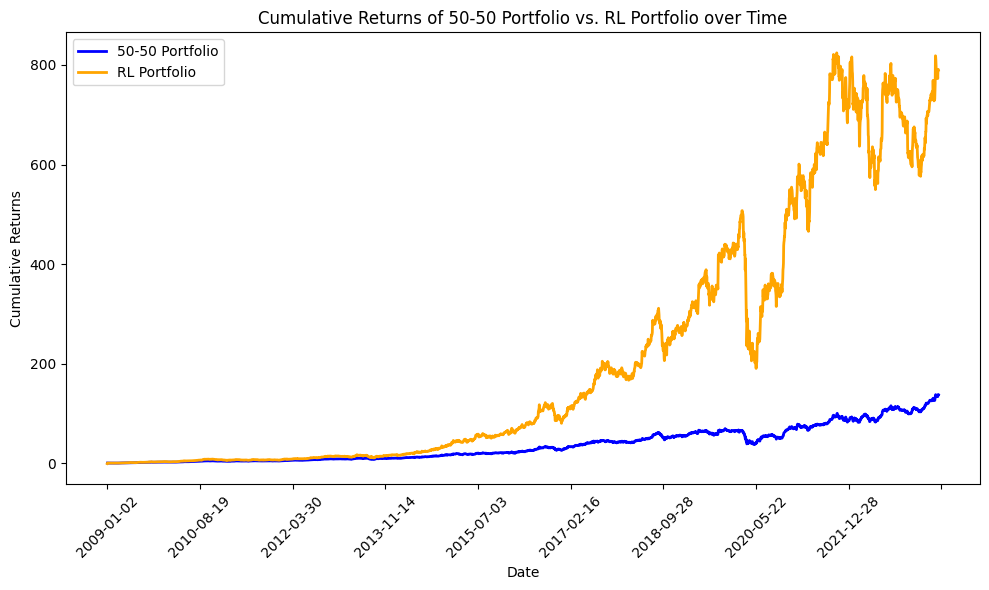

In [324]:
plt.figure(figsize=(10, 6))
plt.plot(dates, cumulative_returns_50_50, label="50-50 Portfolio", color='blue', linewidth=2)
plt.plot(dates, cumulative_returns, label="RL Portfolio", color='orange', linewidth=2)

plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns of 50-50 Portfolio vs. RL Portfolio over Time")
plt.xticks(rotation=45)
tick_interval = 300
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=len(dates)//tick_interval))

plt.legend()
plt.tight_layout()
plt.show()